[Variational AutoEncoders (VAE) with PyTorch](https://avandekleut.github.io/vae/)

In [ ]:
import torch;
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt;
import pandas as pd
import time

In [ ]:
torch.manual_seed(0)
plt.rcParams['figure.dpi'] = 200
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Autoencoder

In [ ]:
class Encoder(nn.Module):
    #  Pythorch usa estos modulos para representar redesneuronales y asi permitir que la clase que   #
    #  que estamos creando sea incluida como un submodulo o subred        #

    def __init__(self, latent_dims, num_features, num_hidden_layers):
        super(Encoder, self).__init__()
        # A continuacion se estaran definiendo 2 capas,
        # de la cual la primera se le estan definiendo
        # 784 Dimensiones(Caracteristicas) de entrada
        # y nos va entregar 512 Dimensiones
        # self.linear1 = nn.Linear(784, 512)
        # Se está definiendo una segunda capa,
        # de la cual la primera se le estan definiendo
        # 512 Dimensiones(Caracteristicas) de entrada
        # y nos va entregar n Dimensiones segun lo definido
        # por el usuario, esta ultima representa el codigo latente
        # que se utilizará para decodificar la imagen.
        # self.linear2 = nn.Linear(512, latent_dims)

        self.linear1 = nn.Linear(num_features, num_hidden_layers)
        self.linear2 = nn.Linear(num_hidden_layers, latent_dims)

    def forward(self, x):
        # la siguiente linea de codigo nos perimte reducir
        # los datos de entrada en una dimesion
        x = torch.flatten(x, start_dim=1)
        # luego activamos la primera capa atravez de relu
        x = F.relu(self.linear1(x))
        # por ultimo con el resultado de se lo enviamos a
        # la segunda capa para producir el codigo latente
        return self.linear2(x)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dims, num_features, num_hidden_layers):
        super(Decoder, self).__init__()
        # En este caso definimos la capa de manera inversa
        # self.linear1 = nn.Linear(latent_dims, 512)
        # self.linear2 = nn.Linear(512, 784)
        self.linear1 = nn.Linear(latent_dims, num_hidden_layers)
        self.linear2 = nn.Linear(num_hidden_layers, num_features)

    def forward(self, z):
        # Activacion de la primera capa
        # a partir del codigo latente
        # obtenido del encoder
        z = F.relu(self.linear1(z))
        # En el resultaod anterior activamos la segunda capa y
        # aplicamos sigmoid para obtener la salida
        # normalizada entre 0 y 1
        z = torch.sigmoid(self.linear2(z)) #Retorna un F1-Score?#
        # Reformateamos la salida a una matriz de un solo canal de 28x28px
        return z.reshape((-1, 1, 28, 28))

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims, num_features, num_hidden_layers):
        super(Autoencoder, self).__init__()
        # El autoencoder se define como la clase que combina 2 redes internas
        # que son correspondientes al encoder y la decoder
        self.encoder = Encoder(latent_dims, num_features, num_hidden_layers)
        self.decoder = Decoder(latent_dims, num_features, num_hidden_layers)
    #Se define el orden de procesamiento
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

## Train Autoencoder

In [ ]:
def train(autoencoder, data, epochs=20):
    # Se usa el metodo de optimzacion Adam
    # el cual reduce gradiente disperso y ruido en los datos.
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, _ in data:
            #se transfiere x a la GPU (si está disponible), lo que acelerará el entrenamiento del modelo.
            x = x.to(device) # GPU
            # Se inicializa el optimzador Adam
            opt.zero_grad()
            # Se hace una predicción de los datos de entrada x utilizando el autoencoder
            x_hat = autoencoder(x)
            # se calcula la pérdida o error del modelo
            loss = ((x - x_hat)**2).sum()
            # Se actualizan los pesos del modelo
            loss.backward()
            opt.step()
    return autoencoder

## Param

In [ ]:
# Se definen 2 dimensiones para que su retorn nos permita graficarlos
latent_dims = 8

# nro. características
num_features = 784 # imagenes 28x28

# nro. capas ocultas
num_hidden_layers = 512

#Se obtiene dataset MNIST
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=128,
        shuffle=True)

#Creamos el objeto autoencoder y pasamos el tensor a GPU de ser posible
# autoencoder = Autoencoder(latent_dims, num_features, num_hidden_layers).to(device) # GPU

#Se entrena el autoencoder
# autoencoder = train(autoencoder, data)

100%|██████████| 9912422/9912422 [00:00<00:00, 103852042.40it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 83715061.38it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29363849.95it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17854291.25it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Plot Autoencoder

In [ ]:
# En 2 dimensiones presenta la informacion del vector latente y entonces de color
# se presentan las etiquetas MNIST(numeros)
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

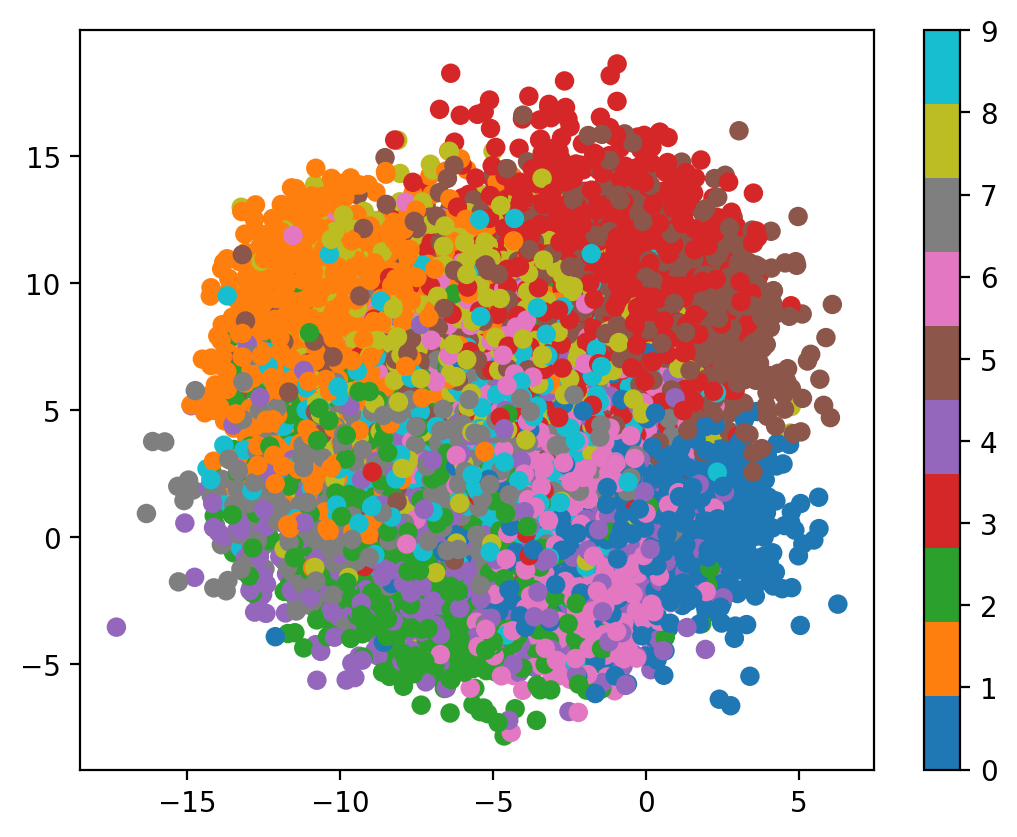

In [ ]:
# Muestra grafico
plot_latent(autoencoder, data)

In [ ]:
# r0 y r1, se pueden considerar como el area seleccionada del gráfico anterior, x & y respectivamente
def plot_reconstructed(autoencoder, r0=(-15, 15), r1=(-25, 10), n=12):
    # Tamaño de la imagen(px)
    w = 28
    img = np.zeros((n*w, n*w))
    # Crea una matriz espaciada de 12 valores dentro del rango de -5 a 10
    for i, y in enumerate(np.linspace(*r1, n)):
        # Crea una matriz espaciada de 12 valores dentro del rango de -10 a 5
        for j, x in enumerate(np.linspace(*r0, n)):
            # Se genera una matriz multidimenacional que será la entrada para el modelo auto encoder
            z = torch.Tensor([[x, y]]).to(device)
            # Se pasa tensor a modelo entrenado y este nos entrega una matriz de 28x28
            x_hat = autoencoder.decoder(z)
            # Se reformatea con el fin de retirar el canal de color
            x_hat = x_hat.reshape(w, w).to('cpu').detach().numpy()
            # A la matriz vacia se le agrega la imagen reconstruida
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
            # Se define la realcion aspecto de la imagen
    plt.imshow(img, extent=[*r0, *r1])

In [ ]:
#Genera el gráfico
plot_reconstructed(autoencoder)

# Variational Autoencoder

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims, num_features, num_hidden_layers):
        super(VariationalEncoder, self).__init__()
        # Se definen 3 capas
        # self.linear1 = nn.Linear(784, 512) # **************** num_features, num_hidden_1 *******************
        # self.linear2 = nn.Linear(512, latent_dims) # Son vectores latentes producidos a travez de la distribucion probabilistica  *************** num_hidden_1, latent_dims ***************
        # self.linear3 = nn.Linear(512, latent_dims)

        self.hidden_1 = nn.Linear(num_features, num_hidden_layers)
        self.z_mean = nn.Linear(num_hidden_layers, latent_dims)
        self.z_log_var = nn.Linear(num_hidden_layers, latent_dims)

        # Se encarga de calcular la distribucion normal para aplicar las distribuciones
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)

        # x = F.relu(self.linear1(x))
        x = F.relu(self.hidden_1(x))

        # mu es la distribucion normal
        mu =  self.z_mean(x) # z_mean

        # Sigma es desviacion estandar(STD)
        # sigma = torch.exp(self.linear3(x)) # z_log_var
        sigma = torch.exp(self.z_log_var(x)/2.) # z_log_var

        # Es el vector del espacio latente
        z = mu + sigma * self.N.sample(mu.shape) # ɛ = self.N.sample(mu.shape)

        # diferencia entre la desviacion estándar y la distribución probabilística
        # self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()

        self.kl = -0.5 * torch.sum(1 + self.z_log_var(x)
                                      - self.z_mean(x)**2 - torch.exp(self.z_log_var(x)), axis=1)
        self.kl = self.kl.mean()
        return z

In [ ]:
class VariationalAutoencoder(nn.Module):
    # Constructor
    def __init__(self, latent_dims, num_features, num_hidden_layers):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims, num_features, num_hidden_layers)
        self.decoder = Decoder(latent_dims, num_features, num_hidden_layers)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
def train(autoencoder, data, epochs=20):
  start_time = time.time()
  opt = torch.optim.Adam(autoencoder.parameters())
  for epoch in range(epochs):
    for batch_idx, (x, y) in enumerate(data):
      x = x.to(device.type) # GPU
      opt.zero_grad()
      x_hat = autoencoder(x)
      # Se agrega perdida axuliar KL
      loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl

      loss.backward()
      opt.step()

      if not batch_idx % 50:
        print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f'
                    %(epoch+1, epochs, batch_idx, len(data)//128, loss))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

  print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
  return autoencoder

In [ ]:
vae = VariationalAutoencoder(latent_dims, num_features, num_hidden_layers).to(device.type) # GPU
vae = train(vae, data)

Epoch: 001/020 | Batch 000/003 | Cost: 23642.4570
Epoch: 001/020 | Batch 050/003 | Cost: 6411.3403
Epoch: 001/020 | Batch 100/003 | Cost: 4461.2397
Epoch: 001/020 | Batch 150/003 | Cost: 3575.1057
Epoch: 001/020 | Batch 200/003 | Cost: 3120.1167
Epoch: 001/020 | Batch 250/003 | Cost: 2902.2527
Epoch: 001/020 | Batch 300/003 | Cost: 2909.9202
Epoch: 001/020 | Batch 350/003 | Cost: 2728.0371
Epoch: 001/020 | Batch 400/003 | Cost: 2617.2876
Epoch: 001/020 | Batch 450/003 | Cost: 2906.5142
Time elapsed: 0.15 min
Epoch: 002/020 | Batch 000/003 | Cost: 2663.1055
Epoch: 002/020 | Batch 050/003 | Cost: 2622.3159
Epoch: 002/020 | Batch 100/003 | Cost: 2606.5764
Epoch: 002/020 | Batch 150/003 | Cost: 2405.5305
Epoch: 002/020 | Batch 200/003 | Cost: 2342.8616
Epoch: 002/020 | Batch 250/003 | Cost: 2567.9631
Epoch: 002/020 | Batch 300/003 | Cost: 2492.0557
Epoch: 002/020 | Batch 350/003 | Cost: 2654.6599
Epoch: 002/020 | Batch 400/003 | Cost: 2138.6787
Epoch: 002/020 | Batch 450/003 | Cost: 2348.7

In [ ]:
for x, y in data:
  print(x.shape)
  print(x.view(-1, 28*28).to(device.type).shape)
  print(x.dtype)
  break

torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.float32


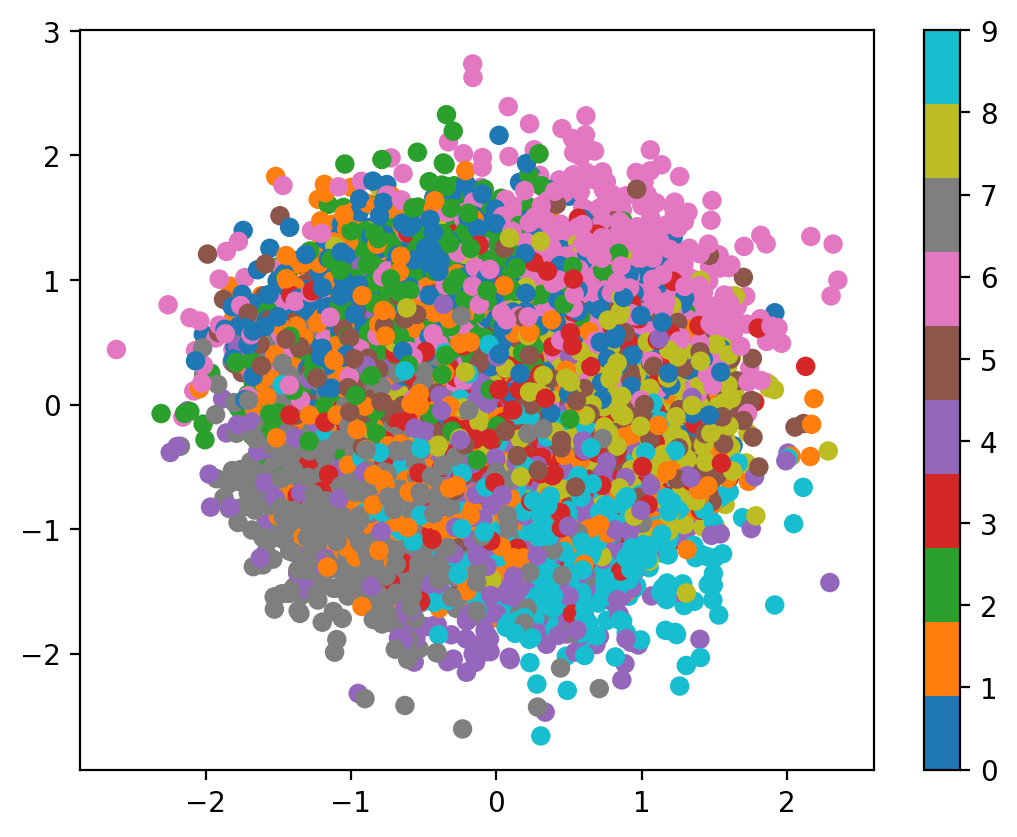

In [ ]:
plot_latent(vae, data)

In [ ]:
plot_reconstructed(vae, r0=(-2, 2), r1=(-2, 2))

RuntimeError: ignored

# Interpolación

In [ ]:
def interpolate(autoencoder, x_1, x_2, n=12):
  # se obtiene el vector latente de cada entrada
  z_1 = autoencoder.encoder(x_1)
  z_2 = autoencoder.encoder(x_2)

  # se apilan los vectores latentes
  # np.linspace(0, 1, n): crea vector espaciado de 0 a 1 con n valores intermedios
  z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])

  # se decodifica el vector latente apilado que debería contener las imagenes originales
  interpolate_list = autoencoder.decoder(z)

  # se mueven los datos obtenidos a la CPU y se convierten a un arreglo numpy
  # detach(): se asegura de que los datos se consideren constantes y no se realice ningún cálculo de gradiente adicional.
  np_interpolate_list = interpolate_list.to('cpu').detach().numpy()

  # la imagenes son cuadradas, por lo tanto solo se define el ancho 28 (28*28 px)
  w = 28
  # se crea arreglo de ceros con w filas y n*w columnas
  # 28 filas: todas las imagenes tienen el mismo alto
  # n*28: se crea espacio para poder apilar horizontalmente imagenes (anchos de imagen)
  img = np.zeros((w, n*w))

  for i, x_hat in enumerate(np_interpolate_list): # obtener fila a fila el resultado del VAE
      img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28) # agrega imagen

  # mostrar resultado
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])

In [ ]:
# se obtiene un batch de información del dataset MNIST
# x: al batch de 128 imagenes de 28*28 px
# y: son las etiquetas de clase del batch, para identificar cada imagen a que número corresponde
x, y = next(data.__iter__())
x_1 = x[y == 1][1].to(device) # seleccionar los números 1
# x_0 = x[y == 0][1].to(device) # seleccionar los números 0
x_0 = x[y == 1][5].to(device)

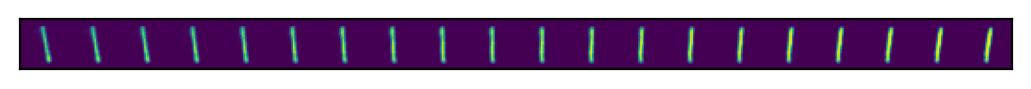

In [ ]:
# obtener 20 números de la interpolación de dos entradas dadas (imagenes con número 1 y 0)
# internamente se obtiene sus vectores latentes
# descodificando los vectores latentes de las dos entradas se produce una fila
# de 20 imágenes que muestran la interpolación entre dígitos.
interpolate(vae, x_1, x_0, n=20)

In [ ]:
from PIL import Image

def interpolate_gif(autoencoder, filename, x_1, x_2, n=100):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)

    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])

    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()*255

    images_list = [Image.fromarray(img.reshape(28, 28)).resize((256, 256)) for img in interpolate_list]
    images_list = images_list + images_list[::-1] # loop back beginning

    images_list[0].save(
        f'{filename}.gif',
        save_all=True,
        append_images=images_list[1:],
        loop=1)

In [ ]:
interpolate_gif(vae, "vae", x_1, x_0, 20)

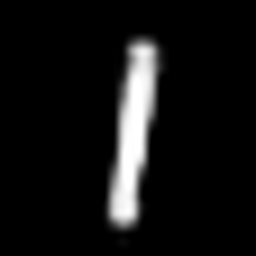

In [ ]:
from IPython.display import Image
Image(open('/content/vae.gif','rb').read())

# TSNE

## TSNE base data

In [ ]:
img.shape

torch.Size([128, 1, 28, 28])

In [ ]:
label.shape

torch.Size([128])

In [ ]:
encoded_img.shape

torch.Size([128, 8])

In [ ]:
from tqdm import tqdm

encoded_samples = np.empty([0,latent_dims])
encoded_labels = np.empty([0,1])

# tqdm() se usa aquí para mostrar una barra de progreso que indica el avance del
# ciclo a medida que se procesan los elementos
for sample in tqdm(data):
  # se toma la info de la imagen y se convierte en un tensor agregando una dimensión en el primer índice
  img = sample[0].squeeze(0).to(device.type)

  #se extrae la etiqueta de clase asociada con la imagen
  label = sample[1]

  # Encode image: se establece el modo de evaluación del modelo, por eficiencia
  vae.eval()
  with torch.no_grad(): # se utiliza para desactivar el seguimiento de gradientes, por eficiencia
      encoded_img  = vae.encoder(img)

  encoded_labels = np.append(encoded_labels, label.numpy())
  encoded_samples = np.append(encoded_samples, encoded_img.cpu().numpy(), axis=0)

# encoded_samples = pd.DataFrame(encoded_samples)
# encoded_samples

100%|██████████| 469/469 [00:08<00:00, 55.73it/s]


In [ ]:
encoded_samples.shape

(60000, 8)

In [ ]:
encoded_samples = np.append(encoded_samples, encoded_labels[:,None], axis=1)
# encoded_samples.drop(9, axis=1)
encoded_samples = pd.DataFrame(encoded_samples, columns=[f'Variable {i}' for i in range(latent_dims)] + ['label'])

In [ ]:
encoded_samples.head()

,Variable 0,Variable 1,Variable 2,Variable 3,Variable 4,Variable 5,Variable 6,Variable 7,label
0,-0.818909,-0.029601,1.172770,-0.052437,-1.536760,0.581026,0.348076,0.741429,0.0
1,-0.416878,-1.250881,0.318983,0.376896,-0.422102,-0.116418,-0.011458,-0.250165,8.0
2,-0.425763,-0.254259,-0.056321,0.879018,0.618073,-0.558706,-0.039380,-1.006582,8.0
3,1.030304,-0.296551,-0.219398,0.726300,1.398501,-0.562132,0.569378,-0.621655,1.0
4,0.816706,-0.655388,-1.047426,0.203375,0.505883,-0.325126,0.863424,-0.366126,6.0


In [ ]:
sample_df = encoded_samples.groupby("label").sample(frac=0.3, random_state=1)

In [ ]:
sample_df.shape

(18000, 9)

In [ ]:
sample_df.groupby("label").count()

,Variable 0,Variable 1,Variable 2,Variable 3,Variable 4,Variable 5,Variable 6,Variable 7
label,,,,,,,,
0.0,1777,1777,1777,1777,1777,1777,1777,1777
1.0,2023,2023,2023,2023,2023,2023,2023,2023
2.0,1787,1787,1787,1787,1787,1787,1787,1787
3.0,1839,1839,1839,1839,1839,1839,1839,1839
4.0,1753,1753,1753,1753,1753,1753,1753,1753
5.0,1626,1626,1626,1626,1626,1626,1626,1626
6.0,1775,1775,1775,1775,1775,1775,1775,1775
7.0,1880,1880,1880,1880,1880,1880,1880,1880
8.0,1755,1755,1755,1755,1755,1755,1755,1755


In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px

px.scatter(encoded_samples, x='Dim 0', y='Dim 1', color=encoded_samples['label'].astype(str), opacity=0.7)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# encoded_samples.fillna(0, inplace=True) # inplace: reemplazar Na por cero

## TSNE VAE

In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples['label'].astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(sample_df.drop(['label'],axis=1))

fig = px.scatter(tsne_results, x=0, y=1, color=sample_df['label'].astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

In [ ]:
## despues de ajuste en espacio latente (/2.)

from sklearn.manifold import TSNE
import plotly.express as px

start_time_tsne = time.time()

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(sample_df.drop(['label'],axis=1))

fig = px.scatter(tsne_results, x=0, y=1, color=sample_df['label'].astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

print('Total Time: %.2f min' % ((time.time() - start_time_tsne)/60))

Total Time: 2.63 min


# import VAE

In [ ]:
!pip install import-ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.6 MB/s eta 0:00:00


In [ ]:
import import_ipynb
import os
from google.colab import files
from importlib import reload
if not os.path.exists("/content/Model_VAE.ipynb"): files.upload()
import Model_VAE as mvae
reload(vae)

importing Jupyter notebook from Model_VAE.ipynb


<module 'Model_VAE' from 'Model_VAE.ipynb'>

In [ ]:
def train2(autoencoder, data, epochs=20):
  start_time = time.time()
  opt = torch.optim.Adam(autoencoder.parameters())
  for epoch in range(epochs):
    for batch_idx, (x, y) in enumerate(data):
      # x = x.to(device.type) # GPU
      x = x.view(-1, 28*28).to(device.type)

      opt.zero_grad() # importante : cada iter empezar grandientes en cero
      x_hat = autoencoder(x)
      # Se agrega perdida axuliar KL
      loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl_divergence

      loss.backward()
      opt.step()

      if not batch_idx % 50:
        print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f'
                    %(epoch+1, epochs, batch_idx, len(data)//128, loss))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

  print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
  return autoencoder

In [ ]:
# usando calculo de eps como CVAE
print("Device:", device)
modelVAE = mvae.VariationalAutoencoder(
              latent_dims= latent_dims,
              num_features= num_features,
              num_hidden_layers= num_hidden_layers
            )
modelVAE = modelVAE.to(device.type)

vae = train2(modelVAE, data)

Device: cuda:1
Epoch: 001/020 | Batch 000/003 | Cost: 23761.7754
Epoch: 001/020 | Batch 050/003 | Cost: 23856.6387
Epoch: 001/020 | Batch 100/003 | Cost: 23783.7832
Epoch: 001/020 | Batch 150/003 | Cost: 23862.8457
Epoch: 001/020 | Batch 200/003 | Cost: 23792.9941
Epoch: 001/020 | Batch 250/003 | Cost: 23780.6738
Epoch: 001/020 | Batch 300/003 | Cost: 23776.5273
Epoch: 001/020 | Batch 350/003 | Cost: 23775.0996
Epoch: 001/020 | Batch 400/003 | Cost: 23763.9160
Epoch: 001/020 | Batch 450/003 | Cost: 23774.4375
Time elapsed: 0.15 min
Epoch: 002/020 | Batch 000/003 | Cost: 23759.5488
Epoch: 002/020 | Batch 050/003 | Cost: 23720.8770
Epoch: 002/020 | Batch 100/003 | Cost: 23756.8379
Epoch: 002/020 | Batch 150/003 | Cost: 23803.1543
Epoch: 002/020 | Batch 200/003 | Cost: 23763.6895
Epoch: 002/020 | Batch 250/003 | Cost: 23851.2637
Epoch: 002/020 | Batch 300/003 | Cost: 23870.1406
Epoch: 002/020 | Batch 350/003 | Cost: 23834.7441
Epoch: 002/020 | Batch 400/003 | Cost: 23727.9023
Epoch: 002/0

In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px

In [ ]:
# usando calculo de eps como CVAE y error opt.zero_grad()
start_time_tsne = time.time()

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples)

fig = px.scatter(
        tsne_results, x=0, y=1,
        color=encoded_labels.astype(str),
        labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'}
      )
fig.show()

print('Total Time: %.2f min' % ((time.time() - start_time_tsne)/60))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# usando calculo de eps como VAE y ajuste opt.zero_grad()
print("Device:", device)
modelVAE = vae.VariationalAutoencoder(
              latent_dims= latent_dims,
              num_features= num_features,
              num_hidden_layers= num_hidden_layers
            )
modelVAE = modelVAE.to(device.type)

vae = train2(modelVAE, data)

Device: cuda:1
Epoch: 001/020 | Batch 000/003 | Cost: 23773.3496
Epoch: 001/020 | Batch 050/003 | Cost: 6455.4307
Epoch: 001/020 | Batch 100/003 | Cost: 4629.4976
Epoch: 001/020 | Batch 150/003 | Cost: 3409.0857
Epoch: 001/020 | Batch 200/003 | Cost: 3314.6917
Epoch: 001/020 | Batch 250/003 | Cost: 3061.1396
Epoch: 001/020 | Batch 300/003 | Cost: 2949.2783
Epoch: 001/020 | Batch 350/003 | Cost: 2875.7478
Epoch: 001/020 | Batch 400/003 | Cost: 2723.1479
Epoch: 001/020 | Batch 450/003 | Cost: 2682.5085
Time elapsed: 0.15 min
Epoch: 002/020 | Batch 000/003 | Cost: 2430.1572
Epoch: 002/020 | Batch 050/003 | Cost: 2740.0317
Epoch: 002/020 | Batch 100/003 | Cost: 2667.4131
Epoch: 002/020 | Batch 150/003 | Cost: 2550.8660
Epoch: 002/020 | Batch 200/003 | Cost: 2405.1616
Epoch: 002/020 | Batch 250/003 | Cost: 2421.3313
Epoch: 002/020 | Batch 300/003 | Cost: 2340.3159
Epoch: 002/020 | Batch 350/003 | Cost: 2319.9094
Epoch: 002/020 | Batch 400/003 | Cost: 2239.5312
Epoch: 002/020 | Batch 450/003

In [ ]:
start_time_tsne = time.time()

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples)

fig = px.scatter(
        tsne_results, x=0, y=1,
        color=encoded_labels.astype(str),
        labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'}
      )
fig.show()

print('Total Time: %.2f min' % ((time.time() - start_time_tsne)/60))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# usando calculo de eps como CVAE y ajuste opt.zero_grad()
print("Device:", device)
modelVAE = vae.VariationalAutoencoder(
              latent_dims= latent_dims,
              num_features= num_features,
              num_hidden_layers= num_hidden_layers
            )
modelVAE = modelVAE.to(device.type)

vae = train2(modelVAE, data)

Device: cuda:1
Epoch: 001/020 | Batch 000/003 | Cost: 23535.9531
Epoch: 001/020 | Batch 050/003 | Cost: 6178.6436
Epoch: 001/020 | Batch 100/003 | Cost: 4555.7271
Epoch: 001/020 | Batch 150/003 | Cost: 3713.4497
Epoch: 001/020 | Batch 200/003 | Cost: 3401.7502
Epoch: 001/020 | Batch 250/003 | Cost: 2878.1880
Epoch: 001/020 | Batch 300/003 | Cost: 2897.5049
Epoch: 001/020 | Batch 350/003 | Cost: 2716.0437
Epoch: 001/020 | Batch 400/003 | Cost: 2622.2097
Epoch: 001/020 | Batch 450/003 | Cost: 2677.0901
Time elapsed: 0.16 min
Epoch: 002/020 | Batch 000/003 | Cost: 2549.5552
Epoch: 002/020 | Batch 050/003 | Cost: 2531.5305
Epoch: 002/020 | Batch 100/003 | Cost: 2534.8723
Epoch: 002/020 | Batch 150/003 | Cost: 2463.2979
Epoch: 002/020 | Batch 200/003 | Cost: 2374.5977
Epoch: 002/020 | Batch 250/003 | Cost: 2320.4126
Epoch: 002/020 | Batch 300/003 | Cost: 2249.1077
Epoch: 002/020 | Batch 350/003 | Cost: 2570.0708
Epoch: 002/020 | Batch 400/003 | Cost: 2306.6145
Epoch: 002/020 | Batch 450/003

In [ ]:
start_time_tsne = time.time()

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples)

fig = px.scatter(
        tsne_results, x=0, y=1,
        color=encoded_labels.astype(str),
        labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'}
      )
fig.show()

print('Total Time: %.2f min' % ((time.time() - start_time_tsne)/60))

Output hidden; open in https://colab.research.google.com to view.